In [1]:
import hdf5storage
from helpers import *
from get_data import *
from synchrony import *
import numpy as np


%load_ext autoreload
%autoreload 2


### Loading in the bat data (LFP and positional data)
#### We first need to load in the LFP data, which in this case is stored in a MATLAB file. We can do this using ```hdf5storage```. The bat's positional data is stored in a matlab file (not accessible for public use), but luckily the accessors for this data can be found in ```dataset.py``` thanks to the Yartsev Lab.

In [2]:
data_path = './data'
bat_id = '32622'
date = '231007'
lfp_file_path = './data/ephys/32622_231007_lfp.mat'


#Clean up position data (remove NaNs, etc.) and load in LFP from given file path
lfp_mat, cleaned_pos, session = load_and_clean_bat_data(data_path, bat_id, date, lfp_file_path,use_cache=True)

Structure of lfp_data: <class 'numpy.ndarray'>, (1, 2)
Loading Flight Room | 32622 | 231007 from cache...
Positional data shape: (841160, 3)
Cleaned positional data shape: (841160, 3)


### Time synchronization
#### Before we get to the main attraction (the LFP data), we need to ensure our data is synchronized. To do this, we need to extract global timestamps from both the LFP and positional data and make sure they start at the same time.

In [3]:
lfp_timestamps_edges, binned_pos, pos_timestamps, lfp_indices, pos_mask = sync_and_bin_data(lfp_mat, session,cleaned_pos)

#lfp_timestamp_edges stores edges between timebins. this will be useful for aligning the LFP data with the position data
#binned_pos is the cleaned position averaged over the timebins
#pos_mask is a boolean array that marks the non-negative position timestamps
#pos_timestamps is the cleaned and filtered timestamps of the position data
#lfp_indices is a boolean array that marks the non-negative, decimated LFP timestamps


LFP timestamps structure: (17222917, 1)
Decimated LFP timestamps shape: (172230,)
LFP timestamp edges shape: (170691,)
Positional timestamp diff (microseconds): [8333.33333331 8333.33333334 8333.33333334 ... 8333.33772278 8333.33771515
 8333.33771515]
Cleaned positional data shape: (824435, 3)
Binned positional data shape: (170690, 3)


In [4]:
print("Number of NaN values in binned_pos:", np.isnan(binned_pos).sum())


Number of NaN values in binned_pos: 6


#### Inside of ```lfp_timestamps_edges```, we store the *edges* between timebins. We will use this to later to bin the position data; instead of downsampling the data like we did the LFP, we will average across bins (between two edges) of the LFP timebins to get synchronized data streams.

In [5]:
print("First few elements of binned_pos:\n", binned_pos[:, :5]) # NaN values at beginning and end are expected; position is not recorded when bat is not visible.

print("First few LFP bins:", lfp_timestamps_edges[:5])

First few elements of binned_pos:
 [[        nan         nan         nan]
 [-1.35497956 -1.70192085  0.01016301]
 [-1.35496366 -1.70190326  0.01020436]
 ...
 [-1.24507387 -1.627617    0.04300965]
 [-1.24505479 -1.62760721  0.0430833 ]
 [        nan         nan         nan]]
First few LFP bins: [     0.           4514.44262606  44057.00577409  83599.56892214
 123142.1320702 ]


##### Notice above that the LFP timestamp edges have N+1 the shape of the binned position. This makes sense and is expected; `lfp_timestamps_edges` contains the bins (which are stored in groups of two, i.e. the first bin is [0, 4514.4426] and so on) for which the position was binned into.

# Ben splits cluster 3

In [6]:
lfp_bat_combined = extract_and_downsample_lfp_data(lfp_mat) #uses scipy decimate to downsample LFP
LFPs = filter_data(lfp_bat_combined, 1, fs=25, filt_type='high', use_hilbert=True) 
LFPs = LFPs[lfp_indices] # mask for non-negativity 

Loading cached LFP data...
LFP combined shape: (172230, 384)


In [7]:
# Extract all flights in the third cluster
flights_cluster = session.get_flights_by_cluster((2,))

# Extract all x-values from the flights
x_values = np.concatenate([flight.filtered_position[:, 0] for flight in flights_cluster])
x_values = x_values[~np.isnan(x_values)]

# Calculate the minimum and maximum x-values
min_x_value = np.min(x_values)
max_x_value = np.max(x_values)

# Calculate the median of the x-values
median_x_value = np.median(x_values)

# Calculate the 3% buffer based on the range of x-values
x_range = max_x_value - min_x_value
buffer = 0.03 * x_range

# Define the range with the buffer around the median
lower_bound = median_x_value - buffer
upper_bound = median_x_value + buffer

print(f"Median x-value position: {median_x_value}")
print(f"Buffer range: ({lower_bound}, {upper_bound})")
# Extract all y-values from the flights
y_values = np.concatenate([flight.filtered_position[:, 1] for flight in flights_cluster])
y_values = y_values[~np.isnan(y_values)]

# Calculate the minimum and maximum y-values
min_y_value = np.min(y_values)
max_y_value = np.max(y_values)

# Calculate the median of the y-values
median_y_value = np.median(y_values)

# Calculate the 3% buffer based on the range of y-values
y_range = max_y_value - min_y_value
buffer_y = 0.03 * y_range

# Define the range with the buffer around the median
lower_bound_y = median_y_value - buffer_y
upper_bound_y = median_y_value + buffer_y

print(f"Median y-value position: {median_y_value}")
print(f"Buffer range: ({lower_bound_y}, {upper_bound_y})")

Median x-value position: 0.6406340942382812
Buffer range: (0.48845591186523435, 0.7928122766113281)
Median y-value position: 0.8960263671875
Buffer range: (0.8311299002431647, 0.9609228341318352)


# color plots of median

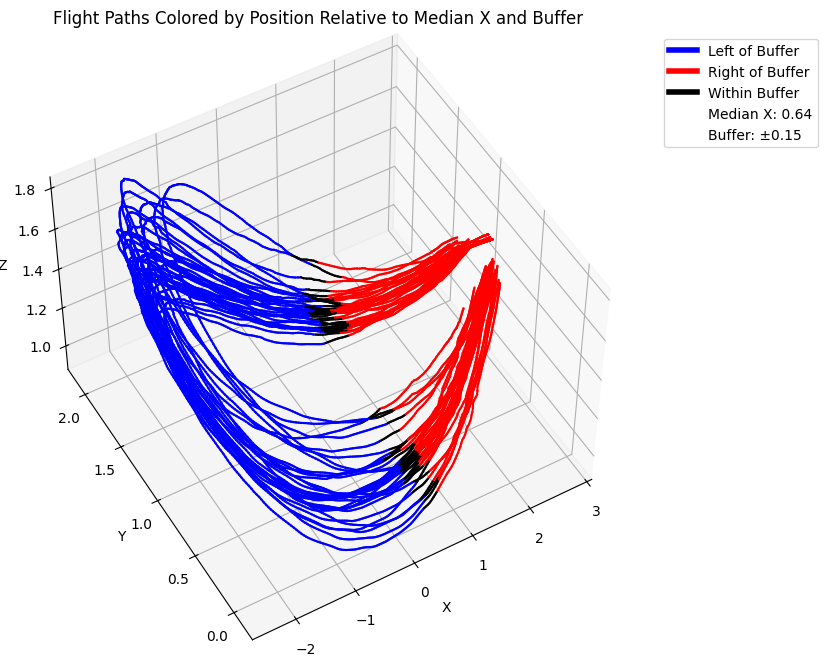

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.lines import Line2D

# Extract all flights in the second cluster
flights_cluster = session.get_flights_by_cluster((2,))

# Extract all x-values from the flights
x_values = np.concatenate([flight.filtered_position[:, 0] for flight in flights_cluster])
x_values = x_values[~np.isnan(x_values)]

# Calculate the median of the x-values
median_x_value = np.median(x_values)

# Calculate the buffer range
x_range = np.max(x_values) - np.min(x_values)
buffer = 0.03 * x_range
lower_bound = median_x_value - buffer
upper_bound = median_x_value + buffer

# Plot 3D flight paths, coloring based on the x-position relative to the median and buffer
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Colors for the regions
left_color = 'blue'
right_color = 'red'
buffer_color = 'black'

for flight in flights_cluster:
    # Extract the position data
    pos = flight.filtered_position
    x_coords, y_coords, z_coords = pos[:, 0], pos[:, 1], pos[:, 2]
    
    # Clean NaN values
    valid_mask = ~np.isnan(x_coords) & ~np.isnan(y_coords) & ~np.isnan(z_coords)
    x_coords, y_coords, z_coords = x_coords[valid_mask], y_coords[valid_mask], z_coords[valid_mask]
    
    # Determine colors for each segment based on x-coordinates
    for i in range(len(x_coords) - 1):
        # Assign color based on the position relative to the buffer
        if lower_bound <= x_coords[i] <= upper_bound:
            segment_color = buffer_color
        elif x_coords[i] < lower_bound:
            segment_color = left_color
        else:
            segment_color = right_color
        
        # Plot the line segment with the determined color
        ax.plot(x_coords[i:i+2], y_coords[i:i+2], z_coords[i:i+2], color=segment_color)

# Set labels for each axis
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set a title for the plot
ax.set_title('Flight Paths Colored by Position Relative to Median X and Buffer')

# Add a legend
legend_handles = [
    Line2D([0], [0], color=left_color, lw=4, label='Left of Buffer'),
    Line2D([0], [0], color=right_color, lw=4, label='Right of Buffer'),
    Line2D([0], [0], color=buffer_color, lw=4, label='Within Buffer'),
    Line2D([0], [0], color='black', lw=0, marker='', markersize=0, label=f'Median X: {median_x_value:.2f}'),
    Line2D([0], [0], color='black', lw=0, marker='', markersize=0, label=f'Buffer: ±{buffer:.2f}')
]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the view
ax.view_init(elev=50, azim=-120)

# Show the plot
plt.show()


In [8]:
def left_or_right(x, lower,upper):
    # Classify the input x values
    return np.where(
        x < lower, "left",  # Values less than the lower buffer are "left"
        np.where(x > upper, "right", "within buffer")  # Values greater than the upper buffer are "right"
    )

##### getting the binned position to match corresponding flights:
flight_count =0
flight_data = []

for flight in session.get_flights_by_cluster([2]): #marking cluster 3 flights
    flight_count +=1
    flight_bool, _, _ = get_flight_boolean_array(session,flight_count)

    # Apply pos_mask (formerly valid_indices) to the flight boolean array and phase labels
    labels = flight_bool[pos_mask]
     # Label timebins for this flight
    timebin_labels = label_timebins(lfp_timestamps_edges, labels, pos_timestamps, is_discrete=True)
    
    flight_lfp = LFPs[timebin_labels > 0] # mark LFP points which mask to specific flight in cluste

     # Get binned position data for this flight
    flight_pos = binned_pos[timebin_labels > 0]
    
####### Current analysis task: marking whether current x is less than or greater than x=0
    flight_data.append(np.column_stack((
        np.full(len(flight_pos), flight_count),
        left_or_right(flight_pos[:,1], lower_bound_y, upper_bound_y),
        flight_lfp
    )))
    


In [9]:
flight_data = np.vstack(flight_data)

In [10]:
flight_data

array([['1', 'left', '(-500.3070232076409+647.6989627071845j)', ...,
        '(415.006904207959+148.09051811485455j)',
        '(469.483962057222+75.63714421360864j)',
        '(533.3019179642059+156.0862412852906j)'],
       ['1', 'left', '(-1542.710432132904-420.2947701574179j)', ...,
        '(559.167079163158+1037.6565609308038j)',
        '(534.384857429464+923.5437032871795j)',
        '(577.6366705379136+1090.6505650047293j)'],
       ['1', 'left', '(-92.09675825681015-1631.16107837899j)', ...,
        '(-1039.0004053648206+505.4811876592816j)',
        '(-821.8673277065101+426.6095645387969j)',
        '(-983.3169612866612+542.5894995690015j)'],
       ...,
       ['34', 'within buffer', '(1386.162516438894+329.961920951532j)',
        ..., '(-59.47863205368271+825.7154359575413j)',
        '(10.452330779130175+697.815306208259j)',
        '(-31.33403557399094+765.8242961234596j)'],
       ['34', 'within buffer', '(492.4793076336379+1110.5098818262322j)',
        ..., '(-932.08

# Spectrogram of each flight w/in cluster 2

Flight 1: LFP stats - mean: (14.759632677146785+13.080434523003401j), std: 2335.226127162483, min: (-8468.580916581946-893.2670538304924j), max: (7224.903881824674+1820.2458416916256j)
Flight 1: Spectrogram stats - min: 4.576067113239788, max: 318164.3841042826, mean: 36682.09582802275
Flight 1: Time bins = 53, Frequency bins = 26


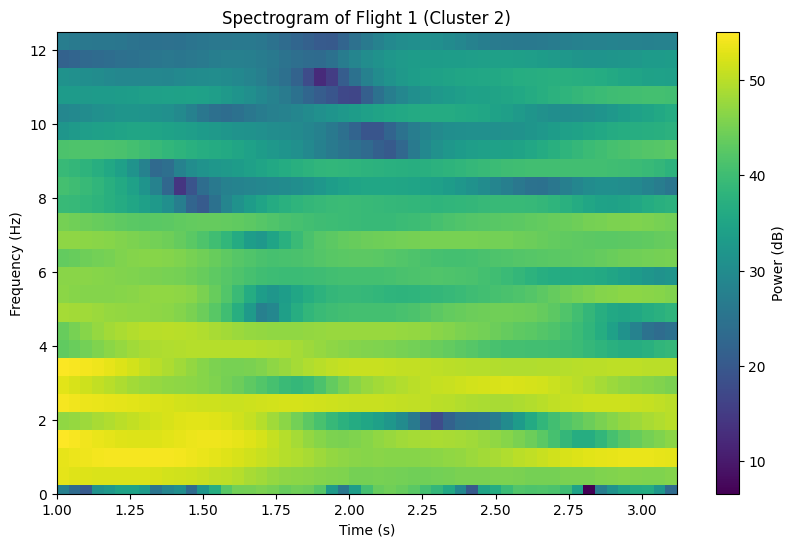

Flight 2: LFP stats - mean: (-2.7552509625545767+9.720281073004262j), std: 2997.4451686439643, min: (-7797.867815837591-3149.8082992326417j), max: (13089.773893032901+5456.097118835546j)
Flight 2: Spectrogram stats - min: 0.03129827863795817, max: 1069962.0547043523, mean: 96284.7091080074
Flight 2: Time bins = 51, Frequency bins = 26


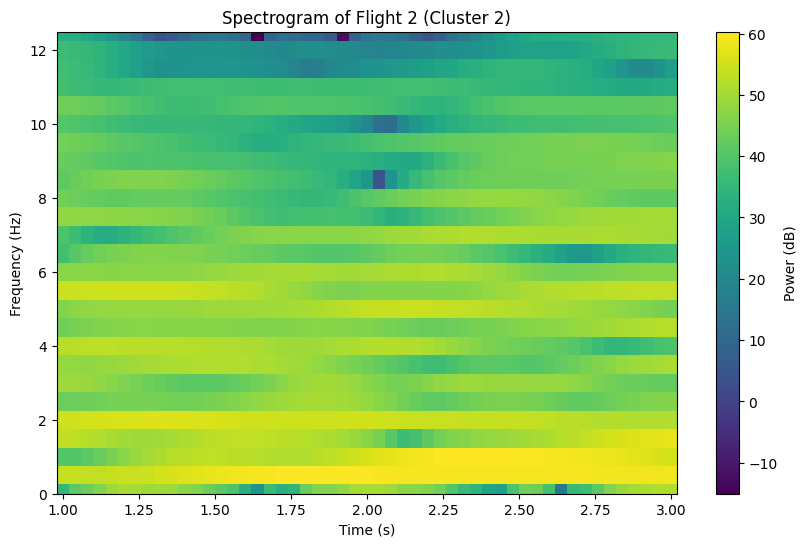

Flight 3: LFP stats - mean: (11.018049619672835-12.63334257754937j), std: 1924.141912775938, min: (-5893.5830345970935-1814.4828084769752j), max: (6932.60180266791+774.9135208065359j)
Flight 3: Spectrogram stats - min: 0.17960627314521238, max: 249493.68952681165, mean: 32822.03884157973
Flight 3: Time bins = 53, Frequency bins = 26


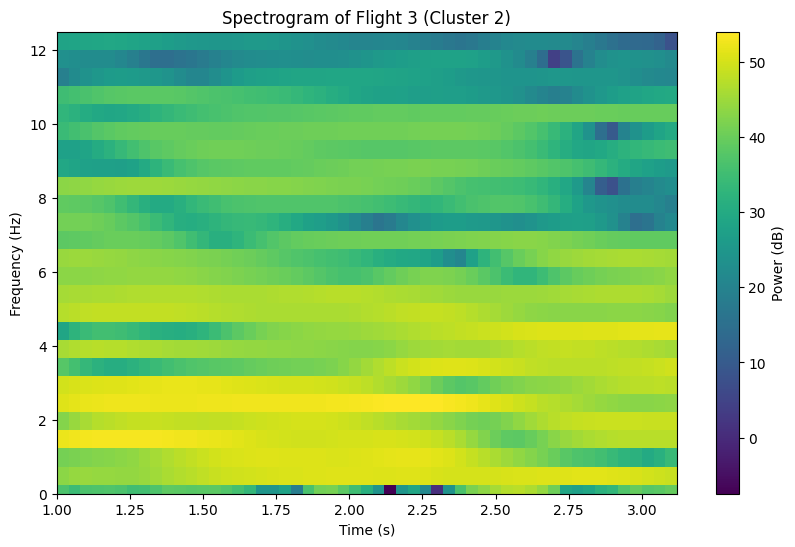

Flight 4: LFP stats - mean: (-38.61003293552564-17.178239891437823j), std: 1780.7362600592444, min: (-6403.403255407444+833.7622152534606j), max: (6502.225842675803+1831.6774254788297j)
Flight 4: Spectrogram stats - min: 0.014829185503793016, max: 227408.49152249726, mean: 22963.303073212406
Flight 4: Time bins = 54, Frequency bins = 27


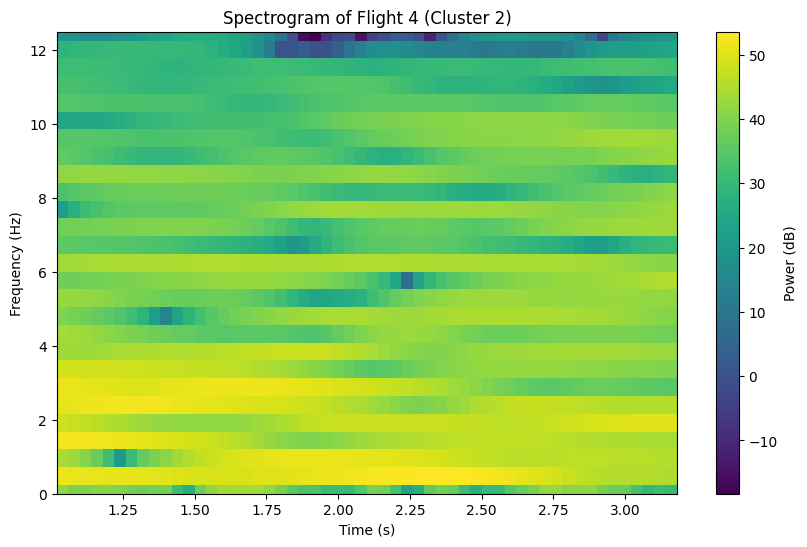

Flight 5: LFP stats - mean: (-2.8405044964129744+16.481250354675794j), std: 1892.9043037860886, min: (-5681.014074216679+473.82179710702803j), max: (7657.650017997578-3586.2655025753847j)
Flight 5: Spectrogram stats - min: 0.7220261797182644, max: 382065.72810837574, mean: 23881.786803296167
Flight 5: Time bins = 53, Frequency bins = 27


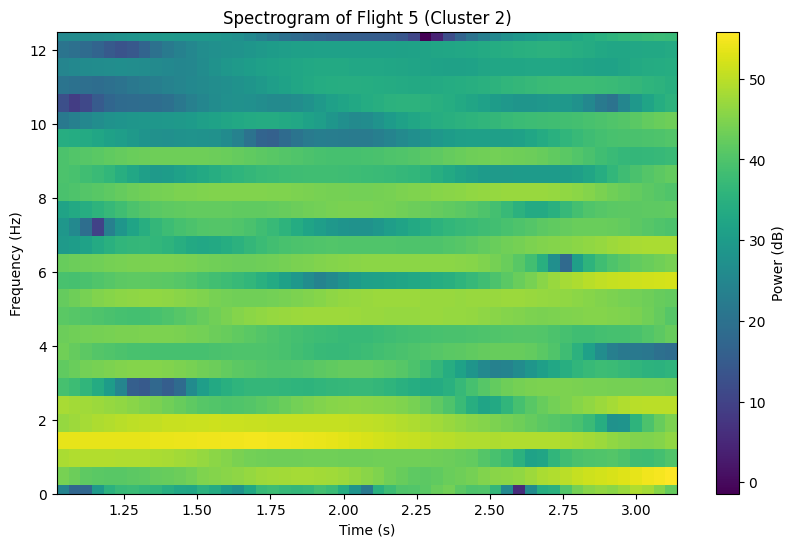

Flight 6: LFP stats - mean: (-1.6886592478760702-32.63054340598817j), std: 2164.05795883233, min: (-6175.1043121316725-2924.693382981437j), max: (7837.039693473051-2032.0811004100165j)
Flight 6: Spectrogram stats - min: 1.121436167510892, max: 532952.3337514636, mean: 36617.776382693315
Flight 6: Time bins = 54, Frequency bins = 27


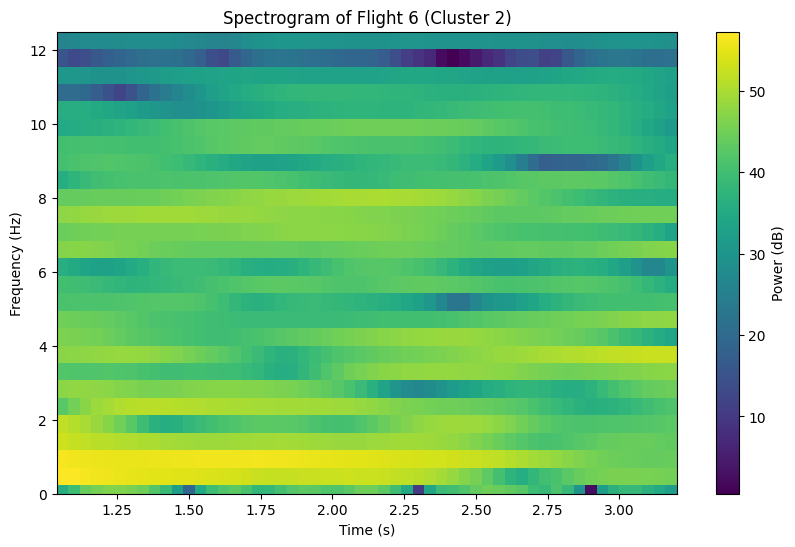

Flight 7: LFP stats - mean: (-15.814432397940438+15.744647655339511j), std: 1592.4336972326878, min: (-4970.164425286583-364.0869075153802j), max: (5345.952525616716-454.3550231864217j)
Flight 7: Spectrogram stats - min: 0.049220586952085275, max: 237639.64167477592, mean: 18351.91152982627
Flight 7: Time bins = 55, Frequency bins = 27


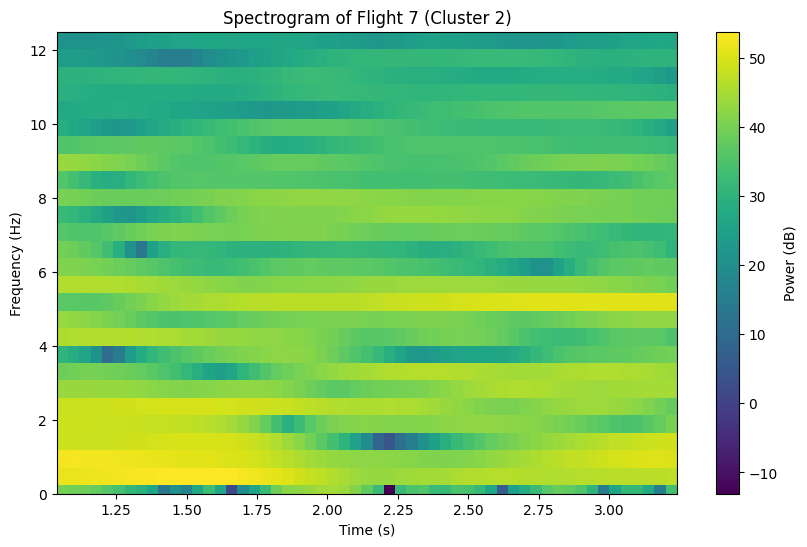

Flight 8: LFP stats - mean: (-13.127988456593227-32.10183251225335j), std: 2319.910997672676, min: (-6738.959074633336-3350.614853693934j), max: (14852.871245689434+2081.617901395132j)
Flight 8: Spectrogram stats - min: 0.005120923921471974, max: 700912.0642980314, mean: 34025.205340612505
Flight 8: Time bins = 58, Frequency bins = 29


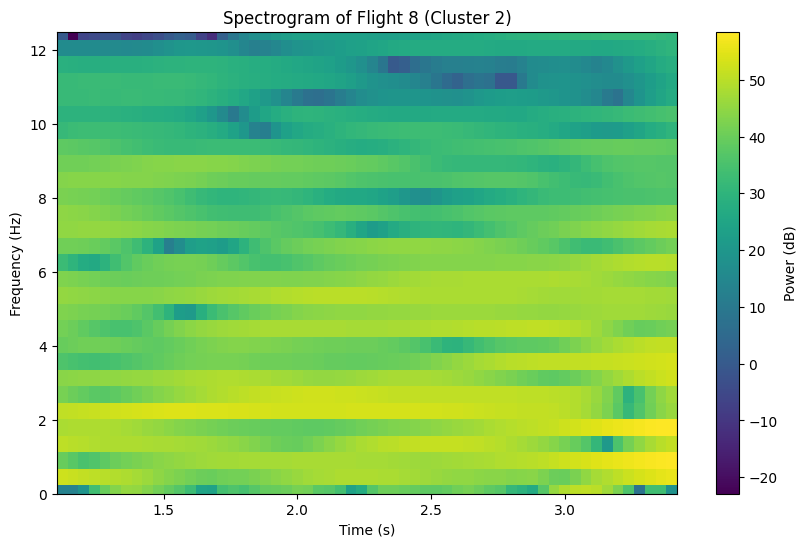

Flight 9: LFP stats - mean: (-33.383841991251884-55.4328388178431j), std: 2141.984850456657, min: (-5771.782320623108+697.5982245581021j), max: (9791.151642900804+2396.8927692417474j)
Flight 9: Spectrogram stats - min: 0.03197566211733613, max: 638412.1578277703, mean: 38438.2782036307
Flight 9: Time bins = 53, Frequency bins = 27


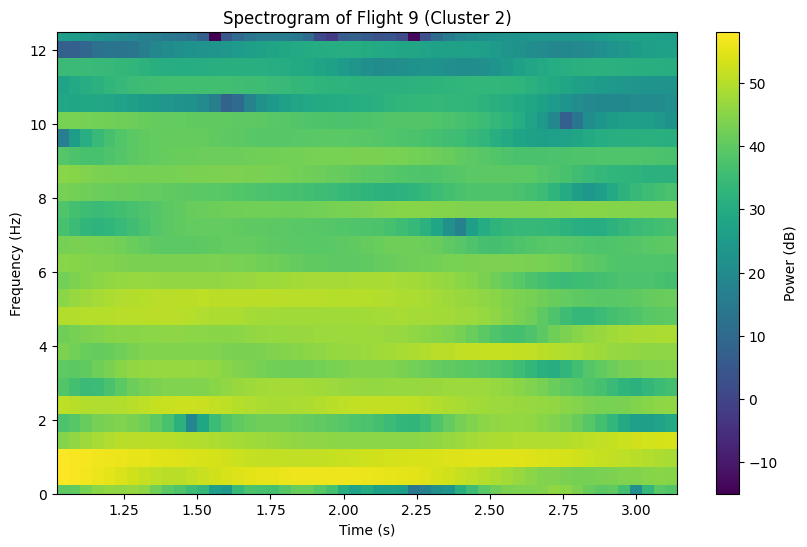

Flight 10: LFP stats - mean: (-11.054784141051524+3.432808437434816j), std: 1776.2129414038939, min: (-4448.151787066156-933.0477829609936j), max: (6343.056910932141+2193.0349205449106j)
Flight 10: Spectrogram stats - min: 3.271447842627506, max: 296539.3950026092, mean: 24716.907289897692
Flight 10: Time bins = 54, Frequency bins = 27


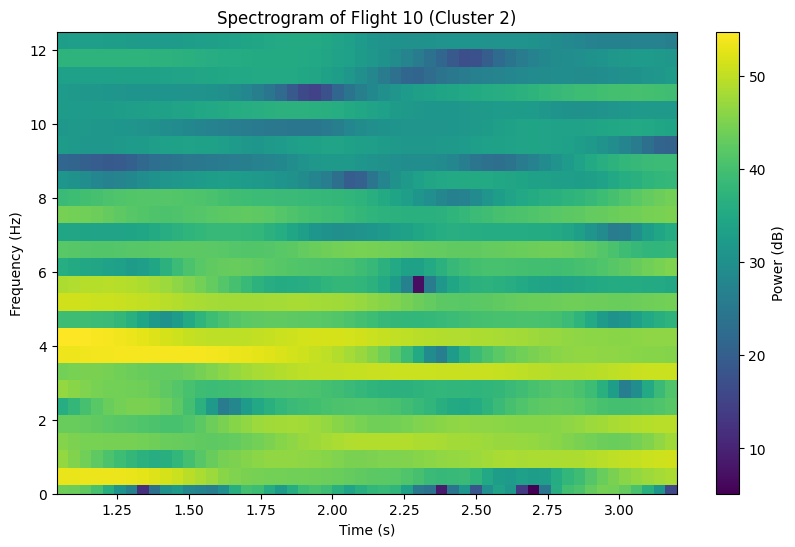

Flight 11: LFP stats - mean: (14.160500902384515-17.49870427296458j), std: 1552.8145920919428, min: (-5777.138302496257+1120.752489192091j), max: (5311.006721689549-1413.8862976071548j)
Flight 11: Spectrogram stats - min: 0.05832721655383323, max: 269957.6292962229, mean: 25456.32198915277
Flight 11: Time bins = 52, Frequency bins = 26


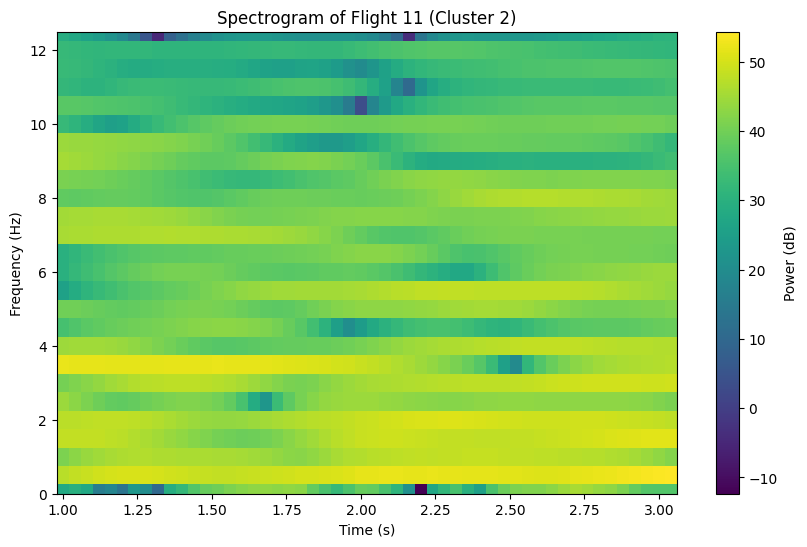

Flight 12: LFP stats - mean: (-3.751198721211603-15.413835744274346j), std: 2388.4199955497925, min: (-9691.883857005332-3132.062132720555j), max: (14521.539522599516+4100.152024154767j)
Flight 12: Spectrogram stats - min: 0.8643830064388162, max: 310679.6913776984, mean: 30369.566044653056
Flight 12: Time bins = 54, Frequency bins = 27


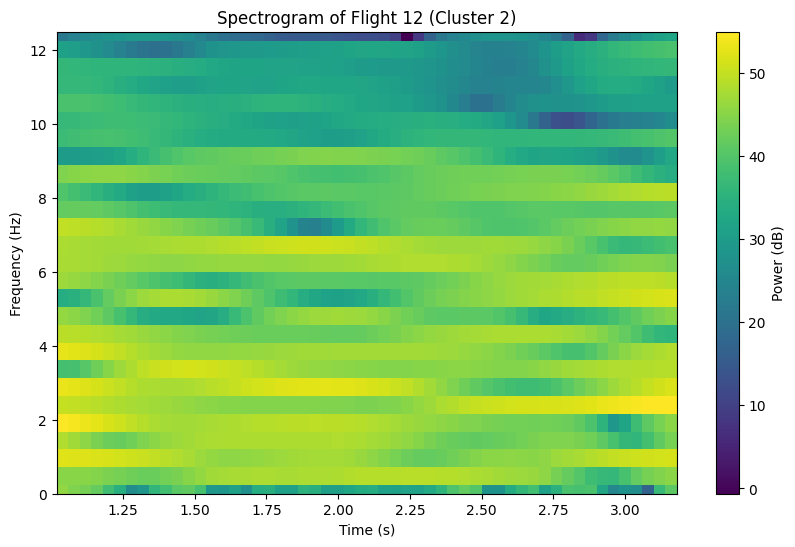

Flight 13: LFP stats - mean: (17.817581375689347+6.130348097465008j), std: 1215.2008714766725, min: (-3973.0438048875335+2023.148423629158j), max: (4341.715972020114+1604.892105159165j)
Flight 13: Spectrogram stats - min: 3.850751524728065, max: 292095.0358079889, mean: 15623.68118452489
Flight 13: Time bins = 53, Frequency bins = 27


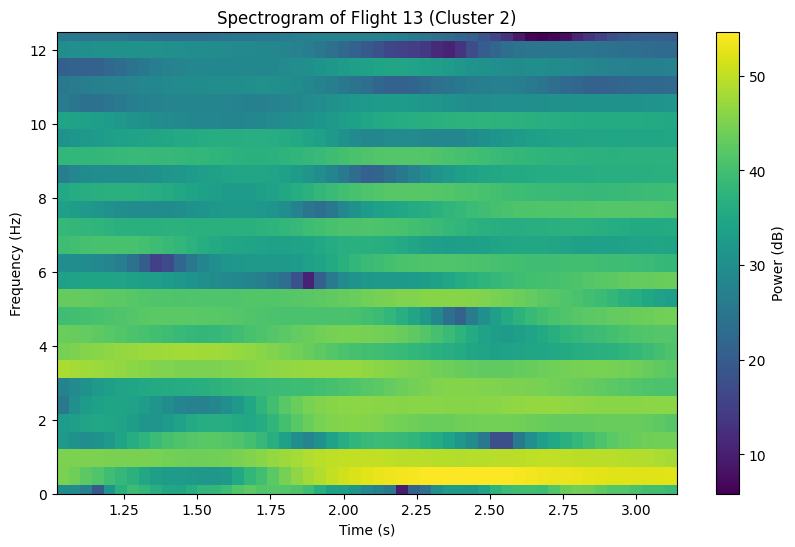

Flight 14: LFP stats - mean: (-15.065911248235833+7.031096642954439j), std: 1827.8892036375112, min: (-4497.553088349941+625.0367554253618j), max: (6349.306258912686+1858.1698252486806j)
Flight 14: Spectrogram stats - min: 0.07596170869576924, max: 225718.12326987158, mean: 21661.817921001013
Flight 14: Time bins = 50, Frequency bins = 25


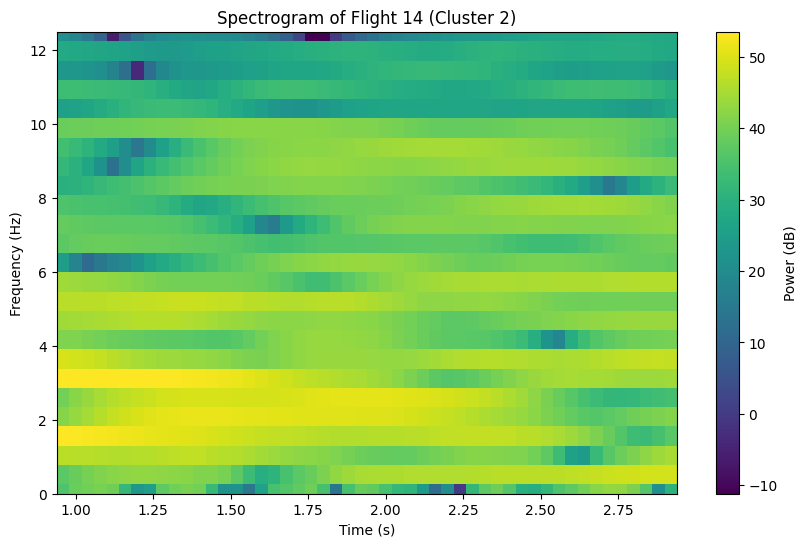

Flight 15: LFP stats - mean: (31.012680907352124+42.844268787709446j), std: 2374.6010446129535, min: (-6402.000505040354-5870.124742957659j), max: (9965.389427956825+1761.1056255124822j)
Flight 15: Spectrogram stats - min: 2.538121650716115, max: 544679.7650281657, mean: 51858.05442429563
Flight 15: Time bins = 56, Frequency bins = 28


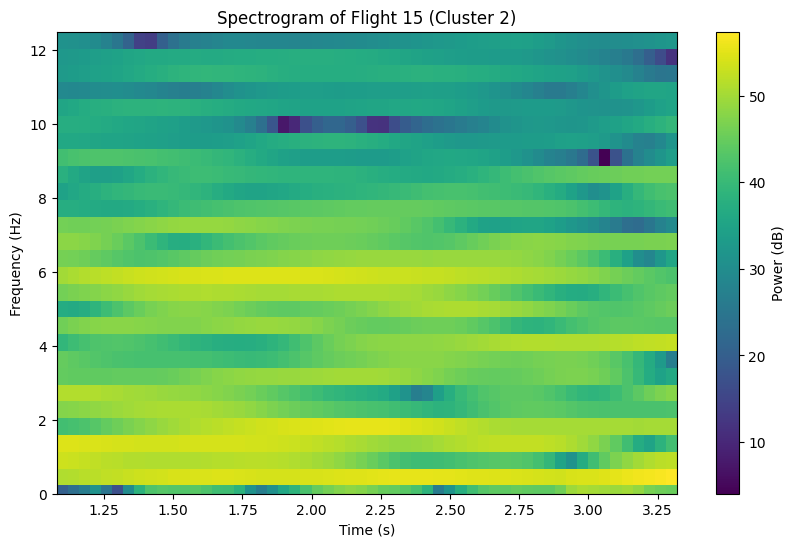

Flight 16: LFP stats - mean: (-9.163104868475994-2.7399172575342523j), std: 2024.4244431685015, min: (-9278.141436276499-1020.5767010957868j), max: (8596.804037023177-2591.636982241213j)
Flight 16: Spectrogram stats - min: 0.7288760503736246, max: 289752.91715720476, mean: 33624.71349079817
Flight 16: Time bins = 52, Frequency bins = 26


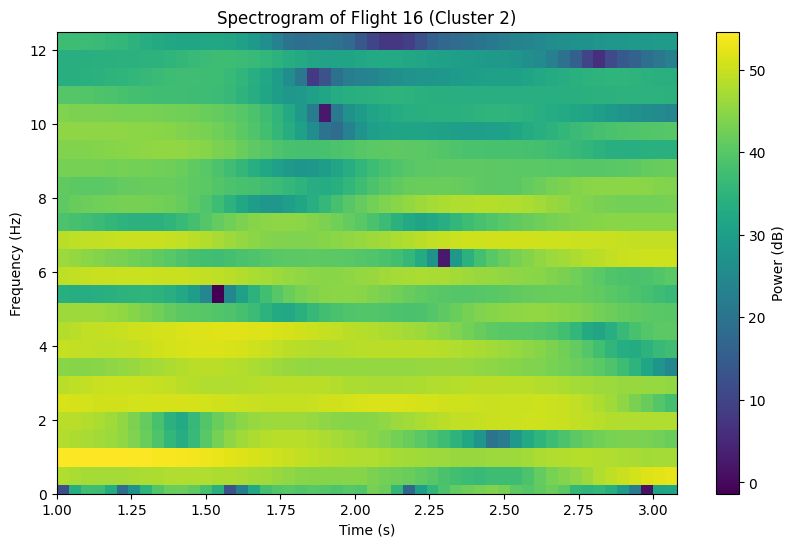

Flight 17: LFP stats - mean: (9.11783238176817+0.012700199323430268j), std: 2064.6391755054756, min: (-9422.81687037353+4526.496247330055j), max: (7711.546282540447-4679.372902890548j)
Flight 17: Spectrogram stats - min: 3.901864950500658, max: 1121544.3420803524, mean: 34107.73427405619
Flight 17: Time bins = 53, Frequency bins = 26


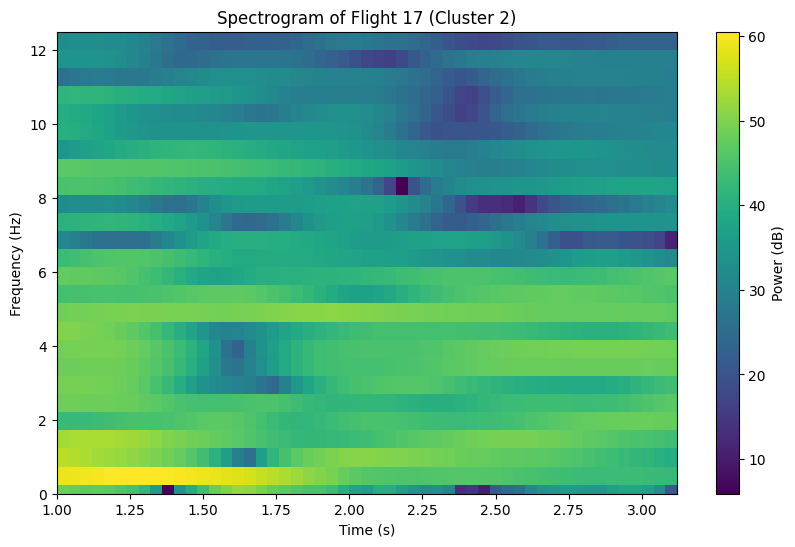

Flight 18: LFP stats - mean: (16.262641360158604+10.526508104970826j), std: 2134.5437130826617, min: (-7113.683393515698+1351.667231774717j), max: (8513.839076021242-85.27821997109483j)
Flight 18: Spectrogram stats - min: 0.15499827449181208, max: 1075186.315852705, mean: 51908.488365386904
Flight 18: Time bins = 53, Frequency bins = 27


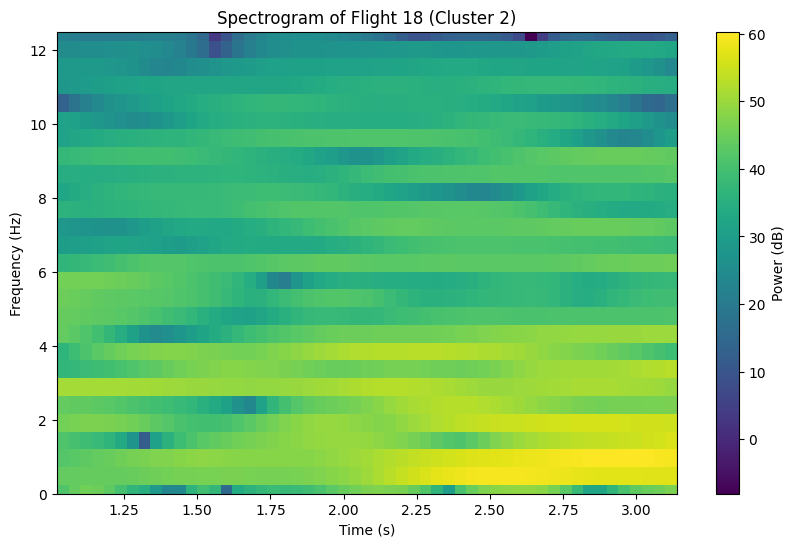

Flight 19: LFP stats - mean: (13.434358909613902-0.20921527650359276j), std: 1477.34985322204, min: (-4202.095293088304+895.9306565836787j), max: (4211.170818496519-1931.989220792508j)
Flight 19: Spectrogram stats - min: 0.4877504671993864, max: 142914.38018241827, mean: 17204.085865839905
Flight 19: Time bins = 53, Frequency bins = 26


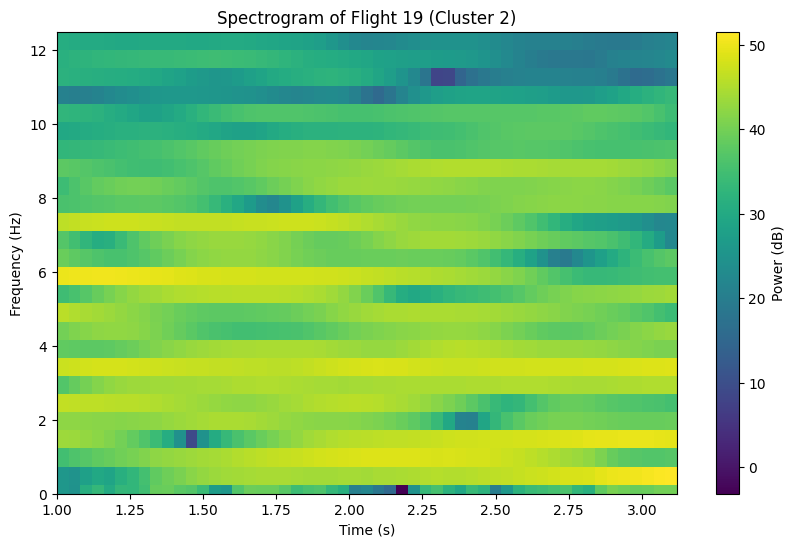

Flight 20: LFP stats - mean: (-12.712002402897353-20.24789014154775j), std: 2835.502163479856, min: (-8026.276044106218+1071.4658984378784j), max: (9317.95903040413+3775.8611153955476j)
Flight 20: Spectrogram stats - min: 4.939791642212282e-05, max: 409468.0163810588, mean: 51766.16330231433
Flight 20: Time bins = 53, Frequency bins = 26


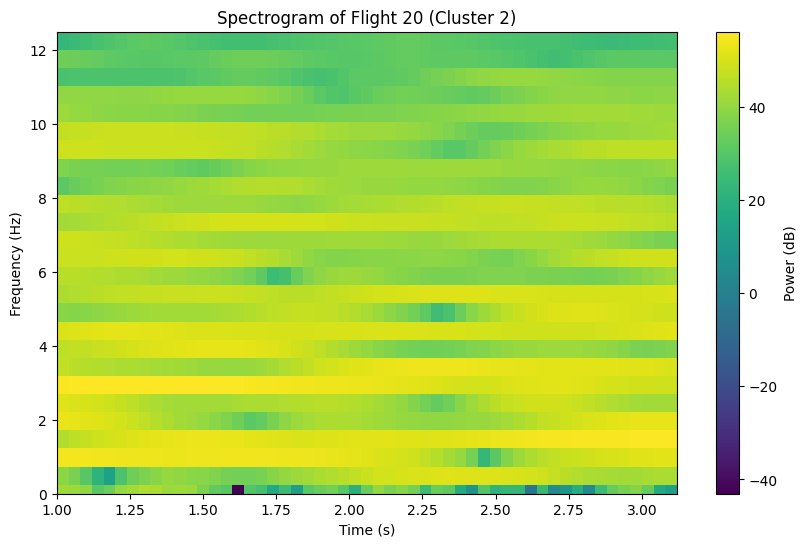

Flight 21: LFP stats - mean: (15.256807396184806+0.5717079884244298j), std: 2249.740353002678, min: (-8253.194167407428-1232.8009478403771j), max: (7710.231576988256+186.5092301863737j)
Flight 21: Spectrogram stats - min: 0.14728894888165978, max: 427751.272911393, mean: 44499.92869513294
Flight 21: Time bins = 53, Frequency bins = 26


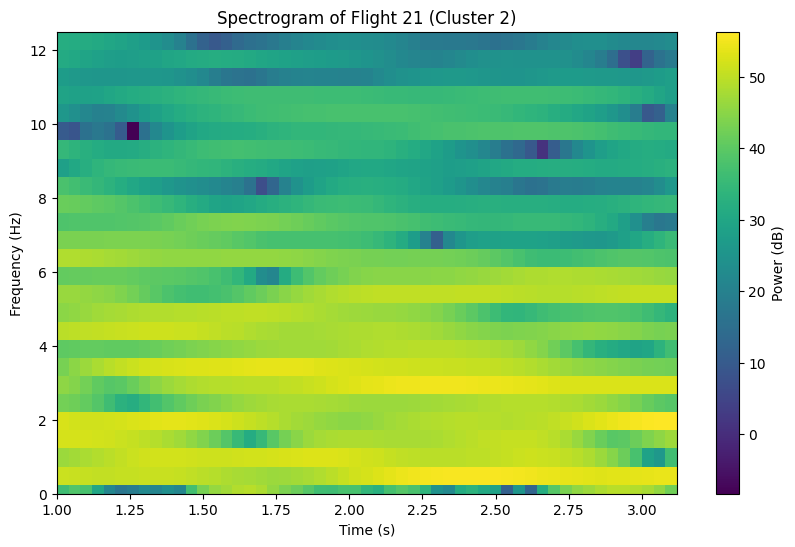

Flight 22: LFP stats - mean: (-68.3675477517704+15.515096651785493j), std: 1946.3803711800242, min: (-6441.372383562849+1148.3191647819929j), max: (8858.784837360014-7232.527824275689j)
Flight 22: Spectrogram stats - min: 1.6983556710139809e-06, max: 361536.66107139277, mean: 41661.53771945844
Flight 22: Time bins = 53, Frequency bins = 27


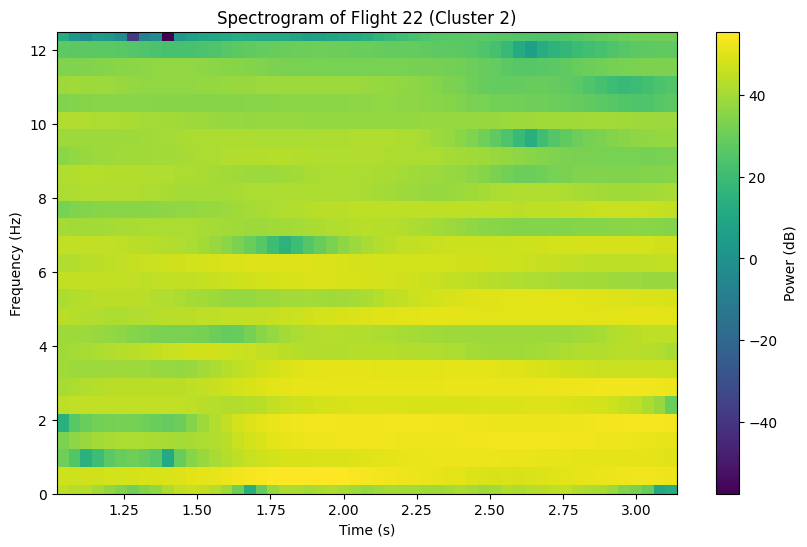

Flight 23: LFP stats - mean: (27.762354635557433-9.908819041228583j), std: 3206.132350694501, min: (-8113.290860750436-271.90231879378445j), max: (15878.779855183533+8749.113075543644j)
Flight 23: Spectrogram stats - min: 4.062194886975989, max: 599249.8940398644, mean: 59352.381620217486
Flight 23: Time bins = 53, Frequency bins = 26


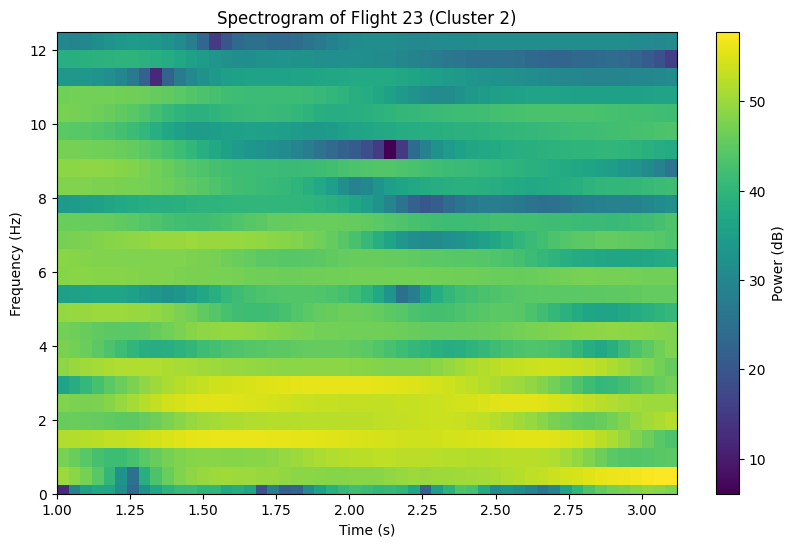

Flight 24: LFP stats - mean: (24.657836038384914+4.401199444667233j), std: 1766.655411976852, min: (-7451.610183504728+1951.0151129382195j), max: (4874.017651465503+1078.5053868311854j)
Flight 24: Spectrogram stats - min: 3.3407377541320784, max: 160487.34633411365, mean: 21292.54759039173
Flight 24: Time bins = 53, Frequency bins = 26


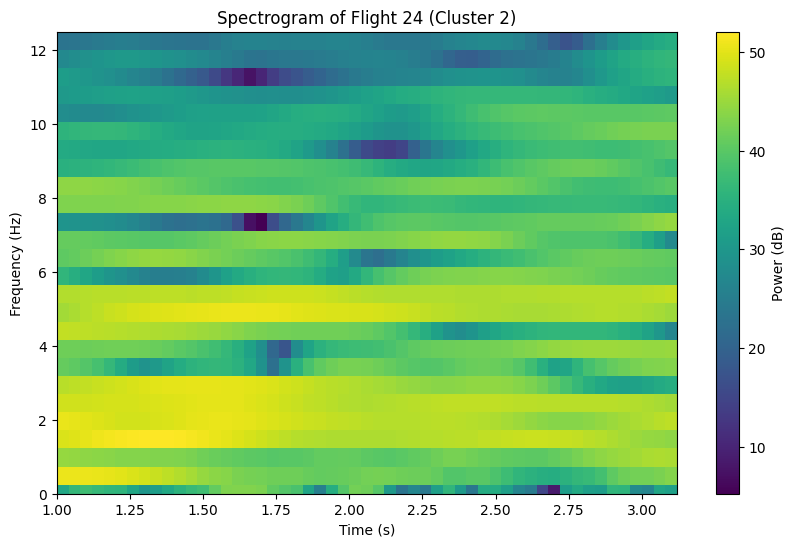

Flight 25: LFP stats - mean: (36.24584777117345+8.23861960366826j), std: 2169.7053175207025, min: (-8581.960907178804-3862.436514350558j), max: (7823.783328909761-3780.182583177791j)
Flight 25: Spectrogram stats - min: 0.06520725166885698, max: 499219.5642655702, mean: 36984.46148822521
Flight 25: Time bins = 52, Frequency bins = 26


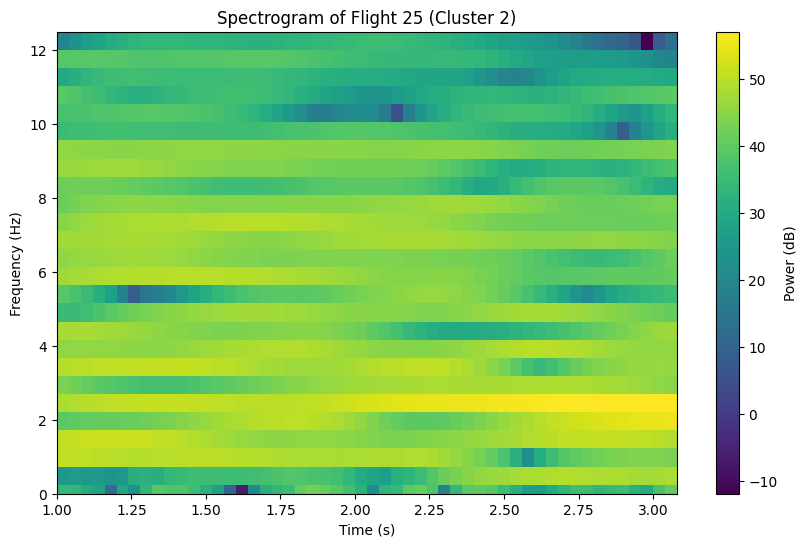

Flight 26: LFP stats - mean: (30.244301683125087-21.51094936285809j), std: 2692.202780699674, min: (-7344.558431515379+3199.8523883114776j), max: (13056.95166787357-402.1800161238309j)
Flight 26: Spectrogram stats - min: 0.015953807753120757, max: 1397832.7646674777, mean: 69829.13073003938
Flight 26: Time bins = 55, Frequency bins = 28


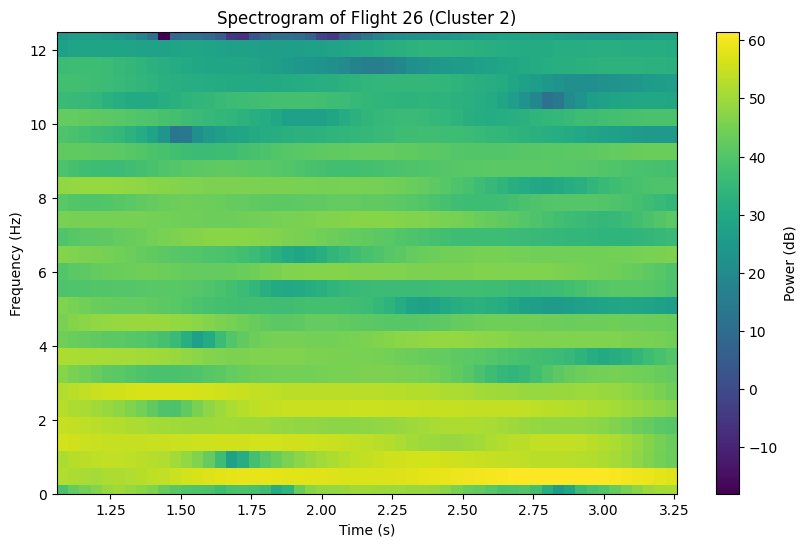

Flight 27: LFP stats - mean: (-1.7752334284939097-16.44565570289605j), std: 2130.288669734277, min: (-6574.423739712303+1858.4998444701816j), max: (6837.654441135732-760.3569527011873j)
Flight 27: Spectrogram stats - min: 1.3481591750337507, max: 506677.3147514111, mean: 41937.42274352157
Flight 27: Time bins = 54, Frequency bins = 27


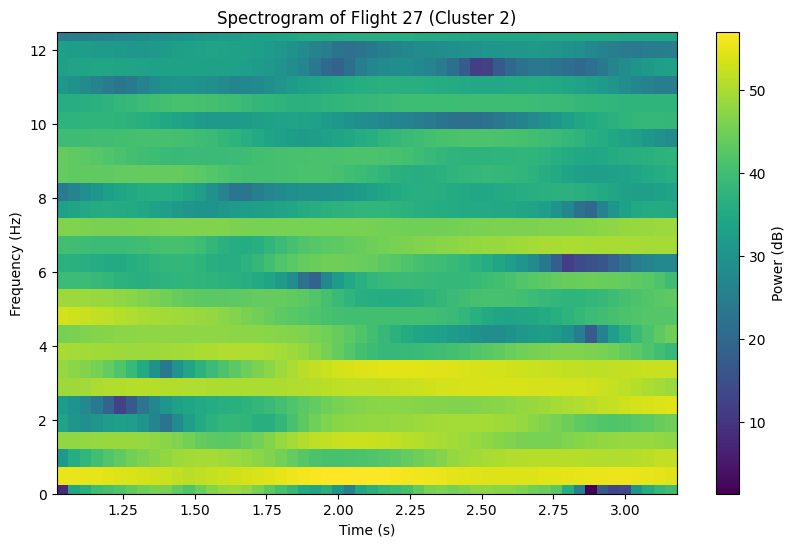

Flight 28: LFP stats - mean: (5.965938754758915-6.19926984070353j), std: 1855.510852354315, min: (-5615.558763736915-997.9261900282435j), max: (6267.605339468338-1360.3448963600035j)
Flight 28: Spectrogram stats - min: 0.30435690814062183, max: 159827.58589303523, mean: 27812.984912959524
Flight 28: Time bins = 55, Frequency bins = 27


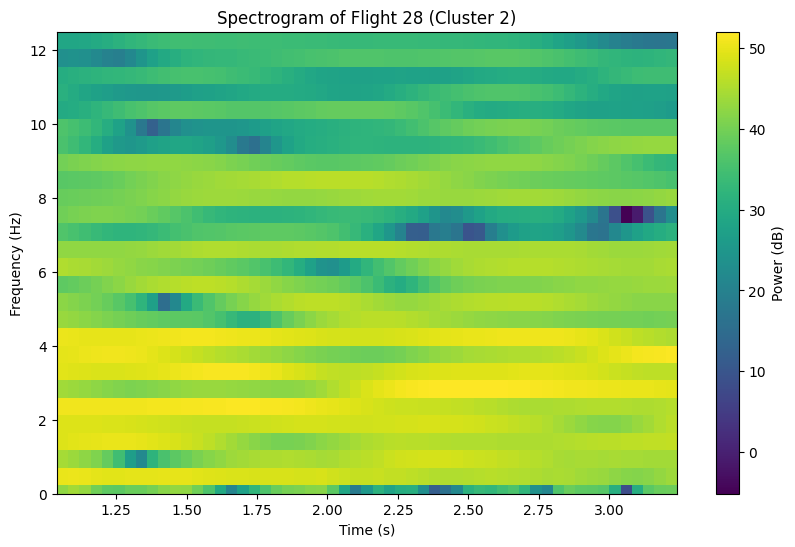

Flight 29: LFP stats - mean: (18.829120797367636+24.542802703431324j), std: 2115.4328992825776, min: (-7114.773357947395-4379.545619764097j), max: (7097.4888667719515-396.65095681476527j)
Flight 29: Spectrogram stats - min: 1.337853395373452, max: 414564.7171105507, mean: 32868.418412621344
Flight 29: Time bins = 54, Frequency bins = 27


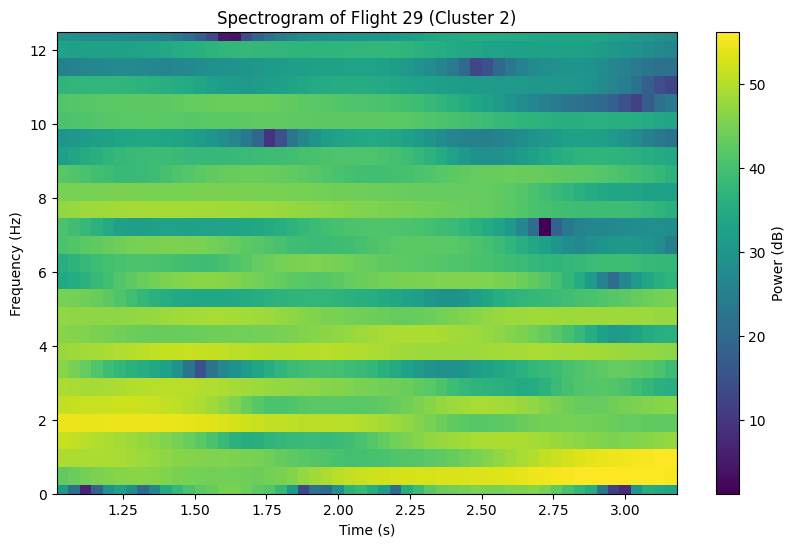

Flight 30: LFP stats - mean: (-12.007269504443626-13.623002981034116j), std: 3157.735077598771, min: (-12435.615880961803-2204.6307264923034j), max: (10441.86977845683+2765.7649608863044j)
Flight 30: Spectrogram stats - min: 1.0898905669503005, max: 654641.1692514182, mean: 84367.81482585399
Flight 30: Time bins = 53, Frequency bins = 27


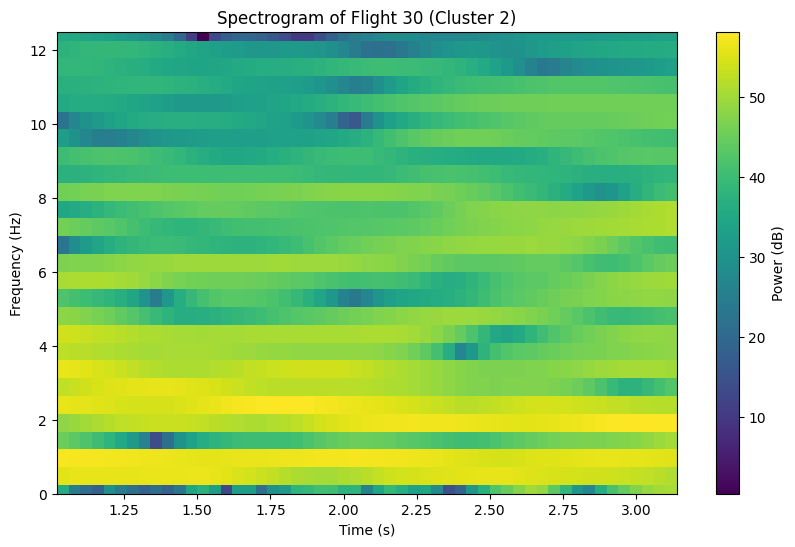

Flight 31: LFP stats - mean: (-1.8463391480529927-28.15255243327991j), std: 1131.2039701284998, min: (-3645.007874070983-2191.7088436009126j), max: (4838.636658976595-1379.664584738785j)
Flight 31: Spectrogram stats - min: 0.9197051990244915, max: 50471.74110592264, mean: 5776.658909002771
Flight 31: Time bins = 52, Frequency bins = 26


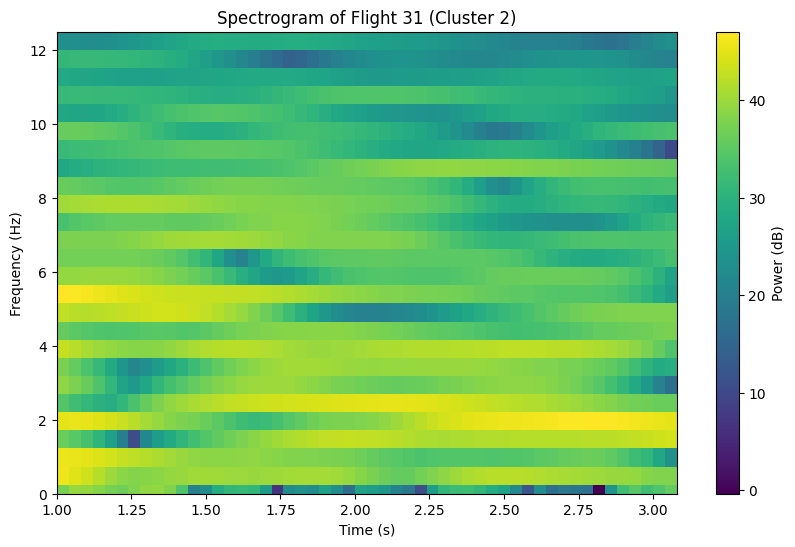

Flight 32: LFP stats - mean: (21.029751502092807-12.93994653849151j), std: 1827.7670931240611, min: (-5621.27483935602+5165.3092505627565j), max: (5677.298054283009+1898.6575275905138j)
Flight 32: Spectrogram stats - min: 0.3404158398537481, max: 148595.52983964872, mean: 24773.263985962585
Flight 32: Time bins = 54, Frequency bins = 27


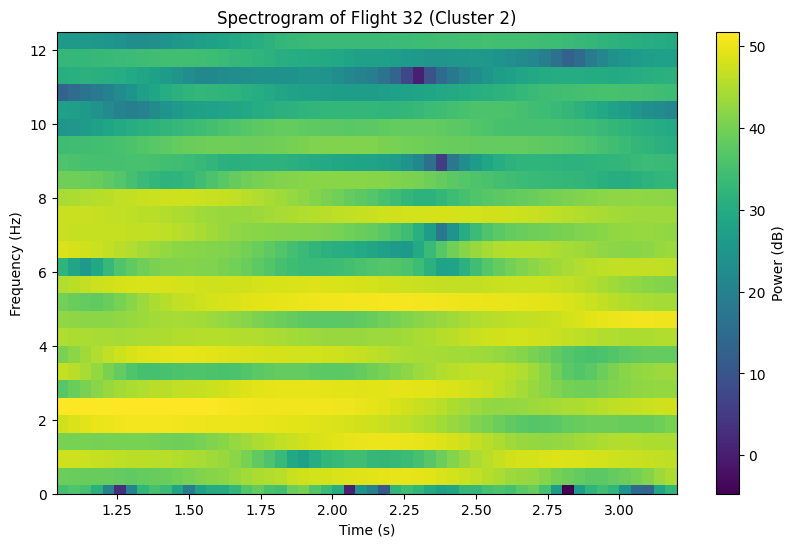

Flight 33: LFP stats - mean: (39.57087926524553+61.103208798320786j), std: 2324.776236778252, min: (-7149.56727902089-174.47485972380525j), max: (9947.248915535745+45.69130959960979j)
Flight 33: Spectrogram stats - min: 0.23896962063986216, max: 401314.15175108286, mean: 44894.28343386662
Flight 33: Time bins = 56, Frequency bins = 28


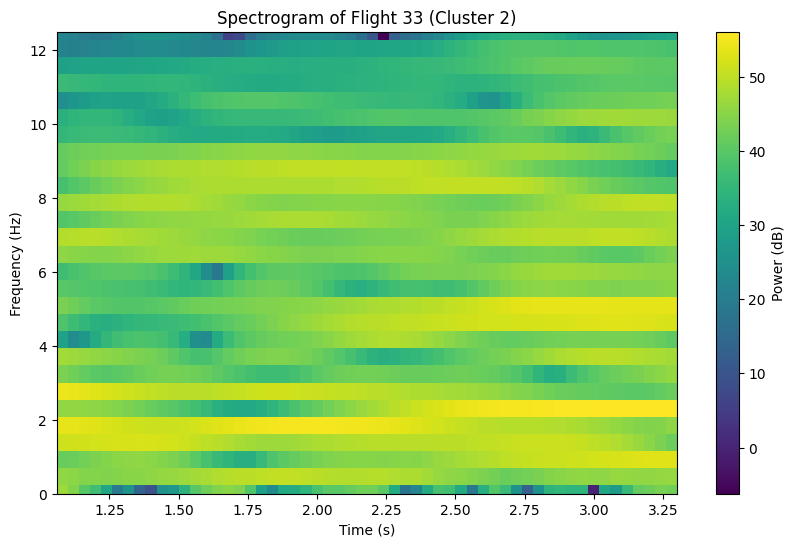

Flight 34: LFP stats - mean: (-6.061131214170213+56.541766195071915j), std: 2631.200544666565, min: (-9672.08468583522+545.772096402604j), max: (9459.753581353023-4975.855745425558j)
Flight 34: Spectrogram stats - min: 3.0083796970339245, max: 706424.2156332568, mean: 64638.77487338154
Flight 34: Time bins = 53, Frequency bins = 26


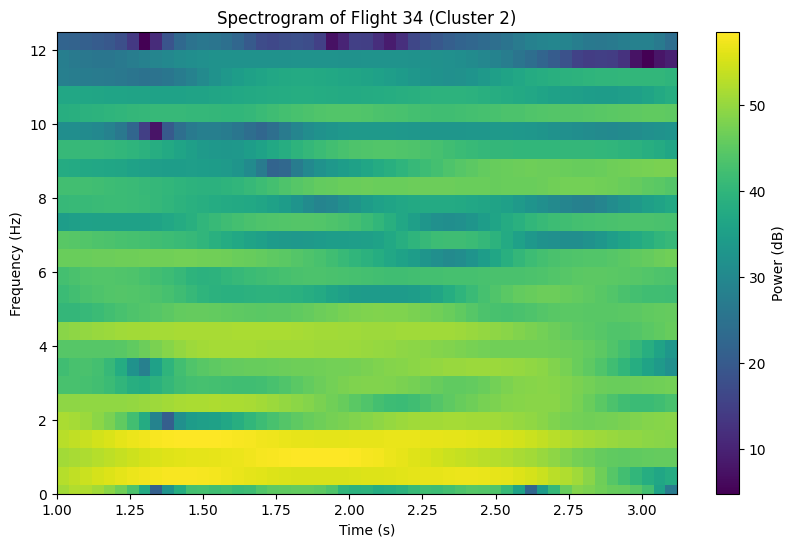

In [57]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, get_window
import numpy as np

# Initialize flight count
flight_count = 0

# Define default parameters for the spectrogram
sampling_rate = 25  # Use the sampling rate of the LFP signal
default_nperseg = 256  # Default segment length
default_noverlap = 128  # Default overlap length
window_type = 'tukey'  # Choose a Tukey window
detrend_type = 'constant'  # Detrend by removing the mean

# Iterate through all flights in cluster 2
for flight in session.get_flights_by_cluster([2]):
    flight_count += 1
    flight_bool, _, _ = get_flight_boolean_array(session, flight_count)

    # Apply pos_mask to the flight boolean array and phase labels
    labels = flight_bool[pos_mask]

    # Label timebins for this flight
    timebin_labels = label_timebins(lfp_timestamps_edges, labels, pos_timestamps, is_discrete=True)

    # Extract LFP data for the current flight
    flight_lfp = LFPs[timebin_labels > 0]

    # Debug: Print basic statistics of `flight_lfp`
    if flight_lfp.size > 0:
        print(f"Flight {flight_count}: LFP stats - mean: {np.mean(flight_lfp)}, std: {np.std(flight_lfp)}, min: {np.min(flight_lfp)}, max: {np.max(flight_lfp)}")
    else:
        print(f"Flight {flight_count}: No LFP data found. Skipping.")
        continue

    # Ensure there's data and handle multi-channel LFPs
    if flight_lfp.size > 0:
        if flight_lfp.ndim > 1:  # Multi-channel LFP
            # Average across channels
            flight_lfp = np.mean(flight_lfp, axis=1)

        # Handle complex input: Use magnitude
        flight_lfp = np.abs(flight_lfp)

        # Scale up the signal if values are too small
        if np.max(flight_lfp) < 1e-6:  # Example threshold for very small values
            print(f"Flight {flight_count}: Scaling up LFP signal.")
            flight_lfp *= 1e6  # Scale up to microvolt range

        # Dynamically adjust `nperseg` and `noverlap` for short signals
        signal_length = len(flight_lfp)
        nperseg = min(default_nperseg, signal_length // 2)  # Use half the signal length if it's too short
        noverlap = min(default_noverlap, nperseg - 1)  # Ensure noverlap < nperseg
        window = get_window(window_type, nperseg)

        # Compute the spectrogram
        f, t, Sxx = spectrogram(
            flight_lfp,
            fs=sampling_rate,
            window=window,
            nperseg=nperseg,
            noverlap=noverlap,
            detrend=detrend_type,
            scaling='density',
            mode='psd',  # Power Spectral Density
            return_onesided=True  # Assuming magnitude data
        )

        # Debug: Print stats of the spectrogram matrix and bins
        print(f"Flight {flight_count}: Spectrogram stats - min: {np.min(Sxx)}, max: {np.max(Sxx)}, mean: {np.mean(Sxx)}")
        print(f"Flight {flight_count}: Time bins = {len(t)}, Frequency bins = {len(f)}")

        # Skip plotting if the spectrogram is empty or contains very small values
        if np.all(Sxx == 0) or np.all(np.isnan(Sxx)) or np.max(Sxx) < 1e-10:
            print(f"Flight {flight_count}: Empty or invalid spectrogram. Skipping plot.")
            continue

        # Plot the spectrogram (focus on low frequencies)
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading="auto")  # Add small constant to avoid log(0)
        plt.colorbar(label="Power (dB)")
        plt.title(f"Spectrogram of Flight {flight_count} (Cluster 2)")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.ylim(0, 12.5)  # Focus on low frequencies (e.g., 0–30 Hz)
        plt.show()
    else:
        print(f"Skipping Flight {flight_count}: No valid LFP data.")


## training TIMBRE

In [11]:
label_mapping = {"left": 0, "right": 1}
classifications = flight_data[:,1]
# Assuming flight_data[:, 2] is a 2D array of strings
# Convert all elements to complex numbers while preserving the original shape
lfp_data = np.array([np.array([complex(val) for val in row]) for row in flight_data[:, 2:]])

# Map the labels to integers
Y = np.array([label_mapping[label] for label in classifications if label != "within buffer"])  # Exclude buffer range

# Extract the LFP data corresponding to non-"0" labels
X = lfp_data[classifications != "within buffer"]  # Use rows where the labels aren't "0"

In [12]:
X

array([[ -500.30702321 +647.69896271j,  -515.55987709 +594.83693525j,
         -498.21230683 +620.02329926j, ...,
          415.00690421 +148.09051811j,   469.48396206  +75.63714421j,
          533.30191796 +156.08624129j],
       [-1542.71043213 -420.29477016j, -1468.80179748 -495.35005044j,
        -1517.40698076 -513.05886221j, ...,
          559.16707916+1037.65656093j,   534.38485743 +923.54370329j,
          577.63667054+1090.650565j  ],
       [  -92.09675826-1631.16107838j,    -6.13454657-1620.49929245j,
           22.03873897-1663.72545517j, ...,
        -1039.00040536 +505.48118766j,  -821.86732771 +426.60956454j,
         -983.31696129 +542.58949957j],
       ...,
       [-1247.01215044-1136.23868535j, -1250.1480422 -1142.89961725j,
        -1312.62880084-1125.37471711j, ...,
          -58.73512593 +822.41350803j,   -64.93498373 +702.21278198j,
         -158.46272026 +774.10820378j],
       [ -144.9623108  +661.73596176j,   -93.29647483 +732.53619488j,
          -62.03987801

In [13]:
# distribution of categorical labels
unique, counts = np.unique(Y, return_counts=True)
total = len(Y)
distribution = {label: (count / total) * 100 for label, count in zip(unique, counts)}
print(distribution)

{0: 50.016989466530745, 1: 49.98301053346925}


In [14]:
Y.shape, X.shape

((2943,), (2943, 384))

In [20]:
from sklearn.model_selection import KFold
from TIMBRE import TIMBRE

k = 3 # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
hidden_nodes=3
learn_rate=0.1
is_categorical=True

# Assuming X and Y are your data and labels
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    print(f"Train indices: {train_index}")
    print(f"Test indices: {test_index}")

    # Use train_index and test_index to index into X and Y
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Call TIMBRE or other model with the current fold's train-test split
    model, fitted_model, test_acc = TIMBRE(
        X=X,
        Y=Y,
        inds_test=test_index,
        inds_train=train_index,
        hidden_nodes=hidden_nodes,
        learn_rate=learn_rate,
        is_categorical=is_categorical,
        verbosity=0
    )

    print(f"Fold {fold + 1} Test Accuracy: {test_acc}")

Fold 1
Train indices: [   0    1    2 ... 2937 2938 2940]
Test indices: [  12   18   25   29   30   32   43   44   45   48   49   51   52   56
   57   59   63   67   69   70   73   76   80   84   87   88   93   96
  100  102  104  108  109  111  120  123  124  134  135  139  141  149
  152  157  162  163  166  168  170  173  175  177  178  179  183  184
  188  194  196  199  203  208  210  211  212  218  219  220  221  226
  229  231  233  237  238  239  240  246  247  251  252  254  256  257
  259  261  263  266  270  272  276  278  279  282  283  289  290  291
  296  297  298  299  303  309  313  314  315  318  321  322  324  325
  331  332  342  343  347  349  350  353  354  358  360  361  365  366
  367  368  381  387  393  402  406  407  408  410  411  414  415  416
  420  422  423  424  430  432  433  435  436  438  439  440  443  445
  449  450  456  457  460  461  462  463  464  471  472  478  479  480
  482  485  486  495  497  498  506  507  508  509  511  518  521  522
  527

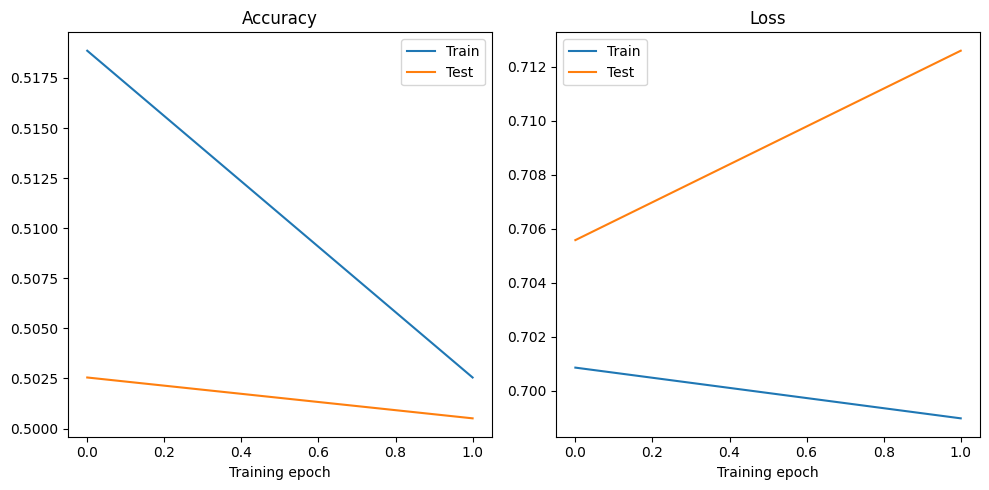

In [21]:
from matplotlib import pyplot as plt

# Plot accuracy and loss from fittedModel
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot training vs. validation accuracy
axs[0].plot(fitted_model.history['accuracy'], label='Train')
axs[0].plot(fitted_model.history['val_accuracy'], label='Test')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Training epoch')
axs[0].legend()

# Plot training vs. validation loss
axs[1].plot(fitted_model.history['loss'], label='Train')
axs[1].plot(fitted_model.history['val_loss'], label='Test')
axs[1].set_title('Loss')
axs[1].set_xlabel('Training epoch')
axs[1].legend()

plt.tight_layout()
plt.show()


In [59]:
from sklearn.model_selection import train_test_split

# Split indices into training and testing sets
inds_train, inds_test = train_test_split(np.arange(len(X)), test_size=0.2, random_state=42)

Testing hidden_nodes=3, iteration=1
Test Accuracy: 0.45670628547668457


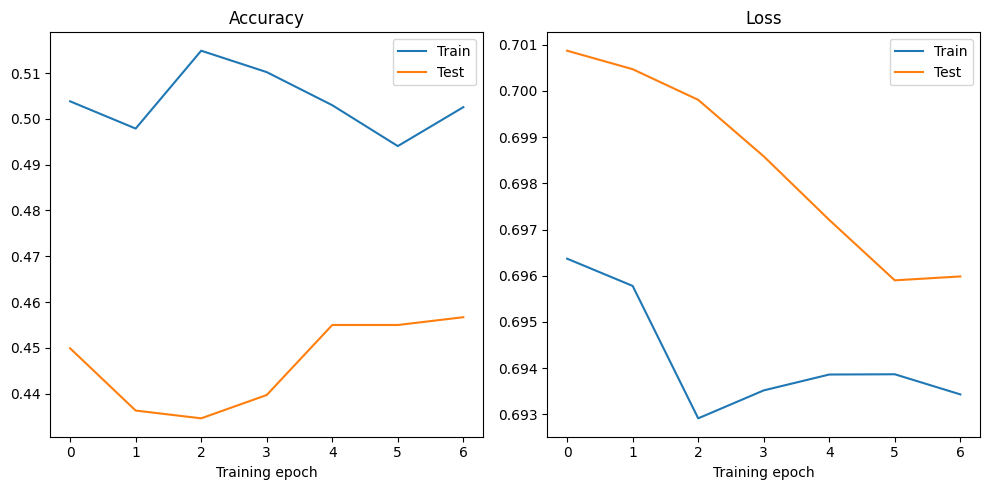

Testing hidden_nodes=3, iteration=2
Test Accuracy: 0.45331069827079773


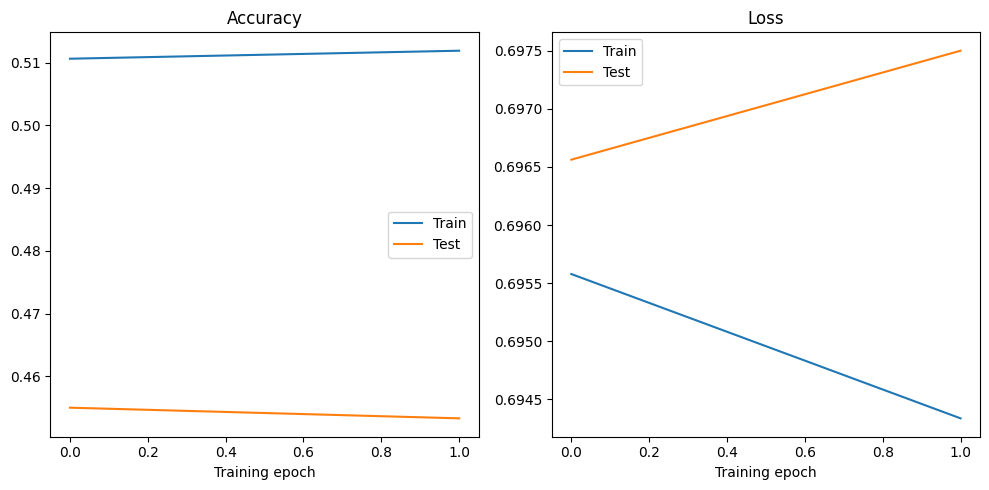

Testing hidden_nodes=3, iteration=3
Test Accuracy: 0.5500848889350891


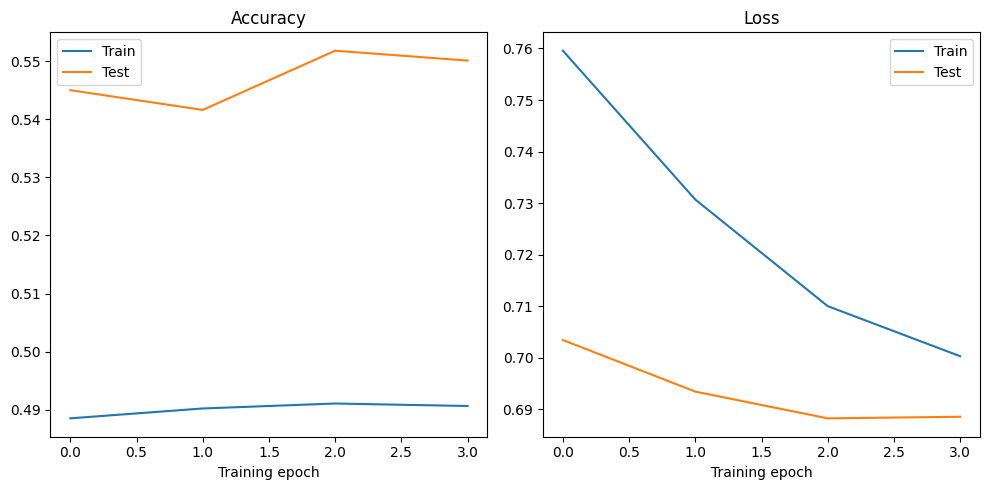

Testing hidden_nodes=10, iteration=1
Test Accuracy: 0.5008488893508911


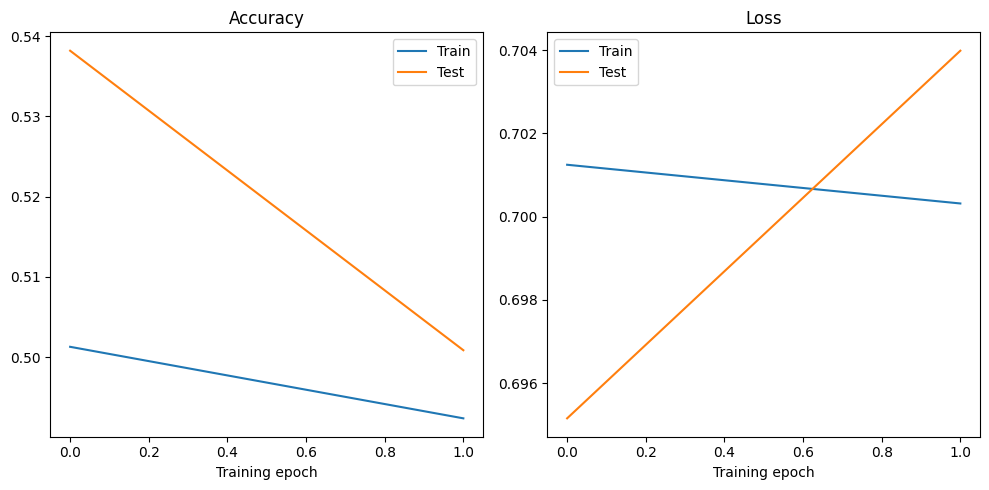

Testing hidden_nodes=10, iteration=2
Test Accuracy: 0.5144312381744385


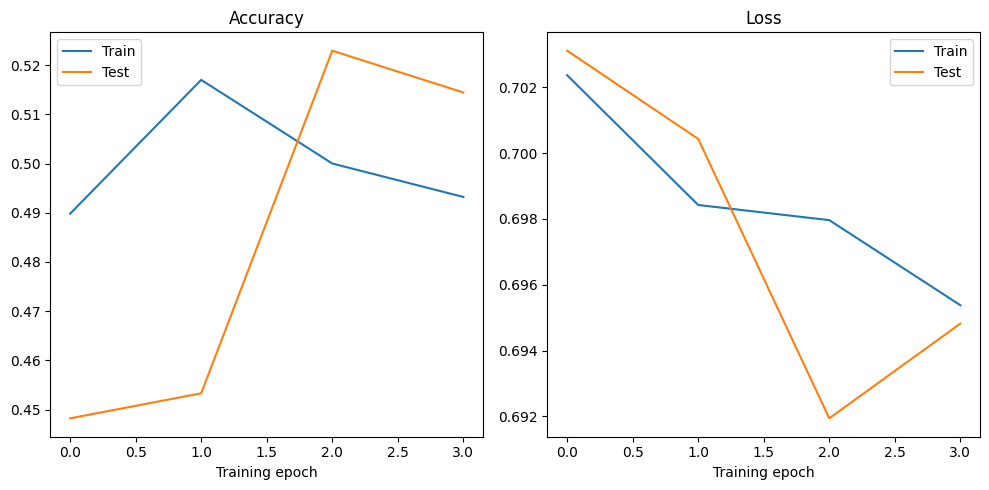

Testing hidden_nodes=10, iteration=3
Test Accuracy: 0.4736842215061188


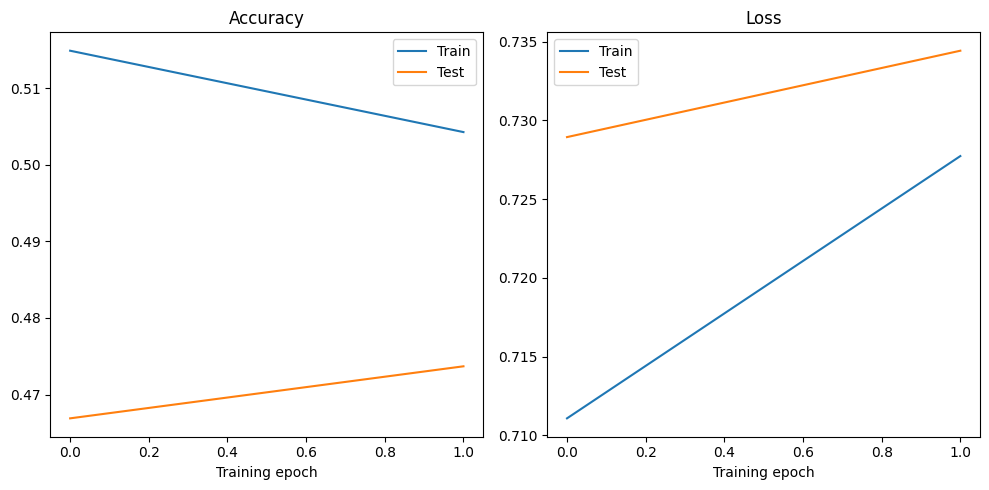

Testing hidden_nodes=30, iteration=1
Test Accuracy: 0.5449914932250977


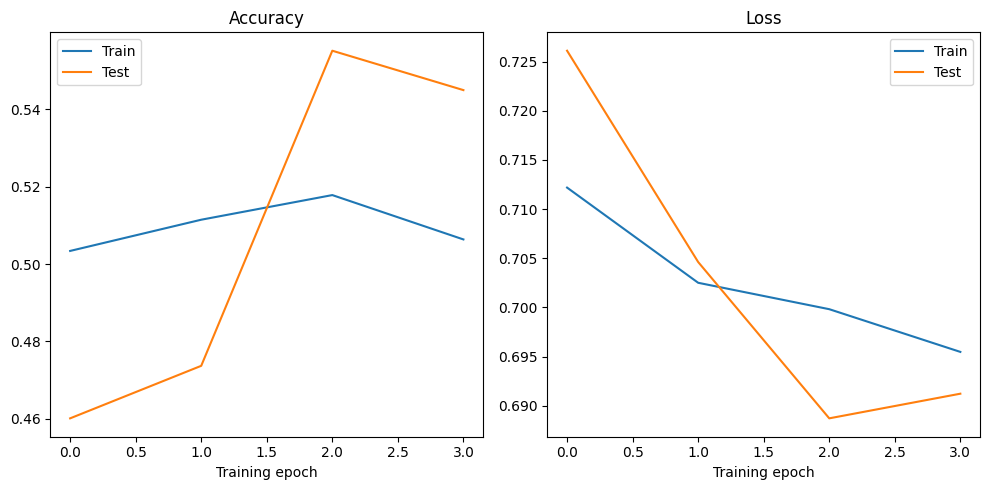

Testing hidden_nodes=30, iteration=2
Test Accuracy: 0.45500847697257996


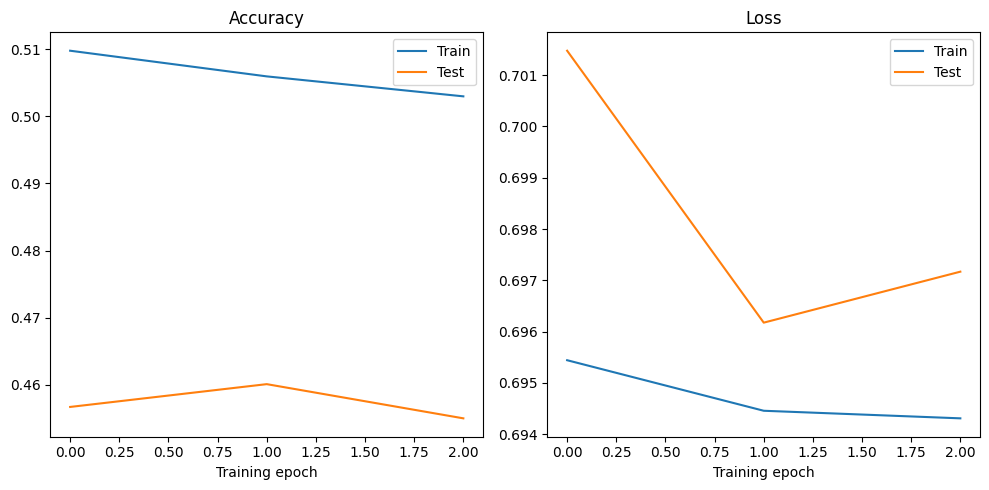

Testing hidden_nodes=30, iteration=3
Test Accuracy: 0.4584040641784668


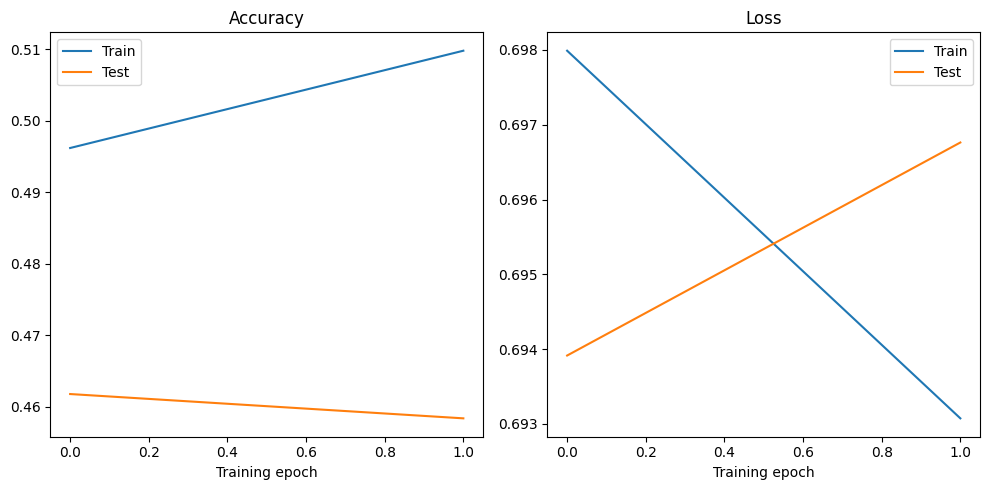


Results:
Hidden Nodes: 3, Accuracies: [0.45670628547668457, 0.45331069827079773, 0.5500848889350891], Average Accuracy: 0.4867006242275238
Hidden Nodes: 10, Accuracies: [0.5008488893508911, 0.5144312381744385, 0.4736842215061188], Average Accuracy: 0.4963214496771495
Hidden Nodes: 30, Accuracies: [0.5449914932250977, 0.45500847697257996, 0.4584040641784668], Average Accuracy: 0.48613467812538147


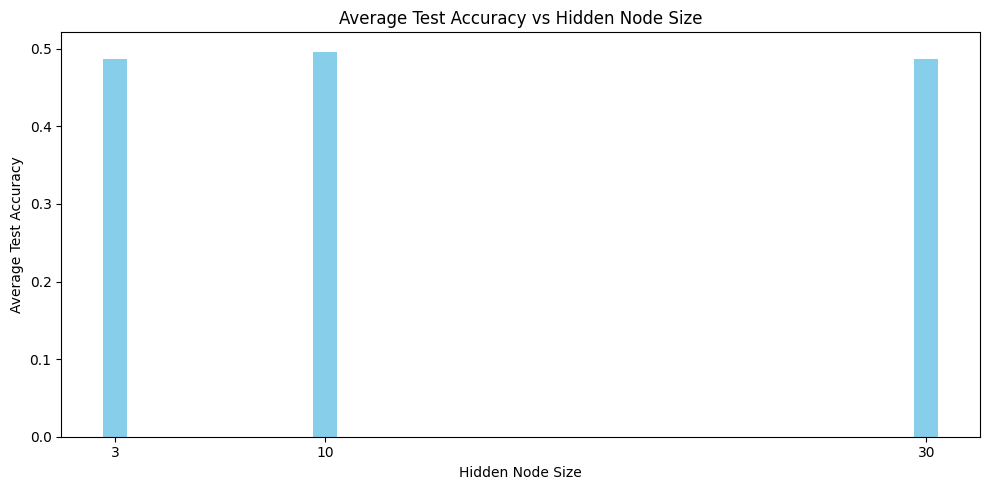

In [60]:
from TIMBRE import TIMBRE
from matplotlib import pyplot as plt
import numpy as np

# Parameters for TIMBRE
hidden_node_sizes = [3, 10, 30]  # Hidden node sizes to test
learn_rate = 0.001
is_categorical = True
iterations = 3  # Number of iterations per hidden node size

# Store results
results = {size: [] for size in hidden_node_sizes}

# Loop over hidden node sizes and iterations
for hidden_nodes in hidden_node_sizes:
    for iteration in range(iterations):
        print(f"Testing hidden_nodes={hidden_nodes}, iteration={iteration + 1}")

        # Call TIMBRE
        model, fitted_model, test_acc = TIMBRE(
            X=X,
            Y=Y,
            inds_test=inds_test,
            inds_train=inds_train,
            hidden_nodes=hidden_nodes,
            learn_rate=learn_rate,
            is_categorical=is_categorical,
            verbosity=0  # Suppress detailed output for cleaner logs
        )

        # Store test accuracy
        results[hidden_nodes].append(test_acc)
        print(f"Test Accuracy: {test_acc}")

        # Plot accuracy and loss from fittedModel
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Plot training vs. validation accuracy
        axs[0].plot(fitted_model.history['accuracy'], label='Train')
        axs[0].plot(fitted_model.history['val_accuracy'], label='Test')
        axs[0].set_title('Accuracy')
        axs[0].set_xlabel('Training epoch')
        axs[0].legend()

        # Plot training vs. validation loss
        axs[1].plot(fitted_model.history['loss'], label='Train')
        axs[1].plot(fitted_model.history['val_loss'], label='Test')
        axs[1].set_title('Loss')
        axs[1].set_xlabel('Training epoch')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

# Calculate average accuracy for each hidden node size
average_accuracies = {size: np.mean(accs) for size, accs in results.items()}

# Print results
print("\nResults:")
for size, accs in results.items():
    print(f"Hidden Nodes: {size}, Accuracies: {accs}, Average Accuracy: {average_accuracies[size]}")

# Plot results
fig, ax = plt.subplots(figsize=(10, 5))

hidden_sizes = list(average_accuracies.keys())
average_accs = list(average_accuracies.values())

ax.bar(hidden_sizes, average_accs, color='skyblue')
ax.set_title("Average Test Accuracy vs Hidden Node Size")
ax.set_xlabel("Hidden Node Size")
ax.set_ylabel("Average Test Accuracy")
plt.xticks(hidden_sizes)
plt.tight_layout()
plt.show()
